In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from datetime import datetime
from pprint import pprint
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

In [2]:
### Produce loan recurrence clean data from current Mongo data for web app

In [3]:
corig = pd.read_csv('companies_sa.csv', dtype={'CompanyNumber': str})

corig = corig[['CompanyName', 'CompanyNumber', 'SICCode', 'CompanyStatus',
               'RegAddress.Country', 'RegAddress.Region', 'IncorporationDate',
               'Mortgages.NumMortCharges']]

print(corig.shape)
corig.head(2)

(4618381, 8)


,CompanyName,CompanyNumber,SICCode,CompanyStatus,RegAddress.Country,RegAddress.Region,IncorporationDate,Mortgages.NumMortCharges
0,! LTD,08209948,"[{""code"":""99999"",""description"":""Dormant Compan...",Active,ENGLAND,YORKSHIRE AND THE HUMBER,2012-09-11T00:00:00.000Z,0.0
1,!? LTD,11399177,"[{""code"":""47710"",""description"":""Retail sale of...",Active,ENGLAND,NORTH WEST,2018-06-05T00:00:00.000Z,0.0


In [4]:
horig = pd.read_csv('charges_sa.csv', dtype={'CompanyNumber': str})

print(horig.shape)
horig.head(2)

(2880040, 9)


,_id,CompanyNumber,charge_number,delivered_on,status,secured_details.description,secured_details.type,particulars.description,particulars.type
0,ObjectId(5d4c1ff81051770017a198bb),00609565,116,1988-02-15T00:00:00.000Z,outstanding,For further securing the moneys secured by the...,amount-secured,All the rights title and interest of the compa...,short-particulars
1,ObjectId(5d4c1ff81051770017a198bc),00609565,115,1988-01-15T00:00:00.000Z,outstanding,For further securing the moneys secured by the...,amount-secured,All the rights title & interest of the company...,short-particulars


In [5]:
horig = horig[['CompanyNumber', 'charge_number', 'delivered_on']]

horig.head(2)

,CompanyNumber,charge_number,delivered_on
0,00609565,116,1988-02-15T00:00:00.000Z
1,00609565,115,1988-01-15T00:00:00.000Z


In [6]:
cedit = corig.copy()
hedit = horig.copy()

## Clean and Merge Data

In [7]:
medit = pd.merge(hedit, cedit, how='right', on='CompanyNumber')

print(medit.shape)
print(len(medit.CompanyNumber.unique())) # ensure zero charges companies are kept
medit.head(2)

(6858045, 10)
4618381


,CompanyNumber,charge_number,delivered_on,CompanyName,SICCode,CompanyStatus,RegAddress.Country,RegAddress.Region,IncorporationDate,Mortgages.NumMortCharges
0,00609565,116.0,1988-02-15T00:00:00.000Z,E.L. COOK ELECTRICAL LIMITED,[],Administration,ENGLAND,EAST MIDLANDS,1958-08-13T00:00:00.000Z,116.0
1,00609565,115.0,1988-01-15T00:00:00.000Z,E.L. COOK ELECTRICAL LIMITED,[],Administration,ENGLAND,EAST MIDLANDS,1958-08-13T00:00:00.000Z,116.0


In [8]:
### Our censors (right-censored). 
medit.tail(2)

,CompanyNumber,charge_number,delivered_on,CompanyName,SICCode,CompanyStatus,RegAddress.Country,RegAddress.Region,IncorporationDate,Mortgages.NumMortCharges
6858043,12292984,NaN,NaN,RICHMOND COMPUTER REPAIR CENTRE LTD,"[{""code"":""95110"",""description"":""Repair of comp...",Active,ENGLAND,LONDON,2019-11-01T00:00:00.000Z,NaN
6858044,12319696,NaN,NaN,CYBERKAI LTD,"[{""code"":""63990"",""description"":""Other informat...",Active,ENGLAND,LONDON,2019-11-18T00:00:00.000Z,NaN


In [9]:
def event(x):
    if x >= 1:
        return 1
    else:
        return 0

In [10]:
def extract_sics(x):
    sic_string = ''
    for i in x.split('"'):
        if i.isdigit():
            sic_string += (str(i) + ' ')
    return sic_string.strip()

In [11]:
medit['RegAddress.Country'].value_counts()[:10]

ENGLAND             6045852
SCOTLAND             385907
WALES                179255
NORTHERN IRELAND     108465
UNKNOWN               58687
UNITED KINGDOM        10689
CHANNEL ISLANDS         505
ISLE OF MAN             381
JERSEY                  293
UNITED STATES           265
Name: RegAddress.Country, dtype: int64

In [12]:
medit = medit[medit['RegAddress.Country'].isin(['ENGLAND', 'SCOTLAND', 'WALES', 'NORTHERN IRELAND '])]
medit = medit[medit.SICCode.notnull()]
medit['Sics'] = medit.SICCode.apply(extract_sics)
medit = medit[medit.Sics.notnull()]
medit = medit[medit.Sics != '']
medit.delivered_on.fillna(value=datetime.now(), inplace=True)
medit.delivered_on = pd.to_datetime(medit.delivered_on, utc=True)
medit = medit[medit.IncorporationDate.notnull()]
medit.IncorporationDate = pd.to_datetime(medit.IncorporationDate, utc=True, errors='coerce')
medit = medit[medit.IncorporationDate > '2000-01-01']
medit['Event'] = medit['Mortgages.NumMortCharges'].apply(event)
medit['Tenure'] = (medit.delivered_on - medit.IncorporationDate).dt.days
medit = medit[medit.Tenure > 0]

print(medit.shape)
medit.head(2)

(4700035, 13)


,CompanyNumber,charge_number,delivered_on,CompanyName,SICCode,CompanyStatus,RegAddress.Country,RegAddress.Region,IncorporationDate,Mortgages.NumMortCharges,Sics,Event,Tenure
602,SC304636,1.0,2006-09-15 00:00:00+00:00,FLEMINGTON SECURITIES LIMITED,"[{""code"":""82990"",""description"":""Other business...",Administration,SCOTLAND,NaN,2006-06-28 00:00:00+00:00,1.0,82990,1,79
636,04191312,148.0,2006-04-25 00:00:00+00:00,TOPLAND PORTFOLIO NO.1 LIMITED,"[{""code"":""41100"",""description"":""Development of...",Liquidation,ENGLAND,LONDON,2001-03-30 00:00:00+00:00,133.0,41100,1,1852


In [13]:
medit.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4700035 entries, 602 to 6858044
Data columns (total 13 columns):
CompanyNumber               4700035 non-null object
charge_number               1156681 non-null float64
delivered_on                4700035 non-null datetime64[ns, UTC]
CompanyName                 4700035 non-null object
SICCode                     4700035 non-null object
CompanyStatus               4700035 non-null object
RegAddress.Country          4700035 non-null object
RegAddress.Region           4300568 non-null object
IncorporationDate           4700035 non-null datetime64[ns, UTC]
Mortgages.NumMortCharges    4480124 non-null float64
Sics                        4700035 non-null object
Event                       4700035 non-null int64
Tenure                      4700035 non-null int64
dtypes: datetime64[ns, UTC](2), float64(2), int64(2), object(7)
memory usage: 502.0+ MB


In [14]:
# breakdown of event vs no event
medit.Event.value_counts()

0    3543354
1    1156681
Name: Event, dtype: int64

In [15]:
medit = medit[['CompanyName', 'CompanyNumber', 'RegAddress.Country',
               'RegAddress.Region', 'Sics', 'IncorporationDate', 'Tenure', 'Event']]

# keeping only the first charge for each company
medit.sort_values(by=['CompanyNumber', 'Tenure'], ascending=True, inplace=True)
medit = medit.loc[medit.groupby('CompanyNumber')['Tenure'].idxmin()]

# confirm only one row per company
print(f'Rows in medit: {len(medit)}')
print(f'Unique company numbers in medit: {len(medit.CompanyNumber.unique())}')

Rows in medit: 3934033
Unique company numbers in medit: 3934033


In [16]:
medit.reset_index(drop=True, inplace=True)

medit.head(2)

,CompanyName,CompanyNumber,RegAddress.Country,RegAddress.Region,Sics,IncorporationDate,Tenure,Event
0,THE PERFORMING RIGHT SOCIETY FOUNDATION,03901665,ENGLAND,LONDON,90020,2000-01-04 00:00:00+00:00,7280,0
1,FOOD ETHICS COUNCIL,03901671,ENGLAND,LONDON,74990,2000-01-04 00:00:00+00:00,7280,0


In [17]:
medit.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3934033 entries, 0 to 3934032
Data columns (total 8 columns):
CompanyName           3934033 non-null object
CompanyNumber         3934033 non-null object
RegAddress.Country    3934033 non-null object
RegAddress.Region     3608895 non-null object
Sics                  3934033 non-null object
IncorporationDate     3934033 non-null datetime64[ns, UTC]
Tenure                3934033 non-null int64
Event                 3934033 non-null int64
dtypes: datetime64[ns, UTC](1), int64(2), object(5)
memory usage: 240.1+ MB


In [18]:
# medit.to_csv('loan_1st_by_sic_new.csv')

In [22]:
medit = medit[['RegAddress.Country', 'RegAddress.Region', 'Sics', 'Tenure', 'Event']]

In [23]:
# medit.to_csv('loan_1st_by_sic_min.csv')

## Start SA 

In [62]:
kmf = KaplanMeierFitter()

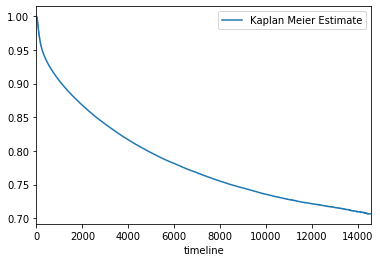

In [63]:
kmf.fit(medit.Tenure, medit.Event, label='Kaplan Meier Estimate')
kmf.plot(ci_show=False)

In [64]:
T = medit.Tenure
E = medit.Event
groups = medit.Sics
type(groups)
chemists = (groups.str.contains('47730'))
dentists = (groups.str.contains('86230'))

In [65]:
medit.loc[dentists[dentists == True].index].head(2)

,RegAddress.Country,RegAddress.Region,Sics,IncorporationDate,Tenure,Event
5071,ENGLAND,SOUTH EAST,86230,1980-12-12 00:00:00+00:00,2891,1
5599,ENGLAND,SOUTH EAST,85590 86230,1981-01-27 00:00:00+00:00,14195,0


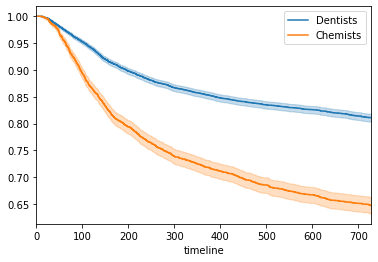

In [66]:
kmf1 = KaplanMeierFitter()

## fit the model for 1st cohort
kmf1.fit(T[dentists], E[dentists], label='Dentists')
a1 = kmf1.plot(loc=slice(0, 730))

## fit the model for 2nd cohort
kmf1.fit(T[chemists], E[chemists], label='Chemists')
kmf1.plot(ax=a1, loc=slice(0, 730))

In [68]:
dedit = medit.copy()
dedit = dedit[dedit.Sics.str.contains('86230')]

T2 = dedit.Tenure
E2 = dedit.Event
groups = dedit['RegAddress.Region']
ldn = (groups == 'LONDON')
se = (groups == 'SOUTH EAST')

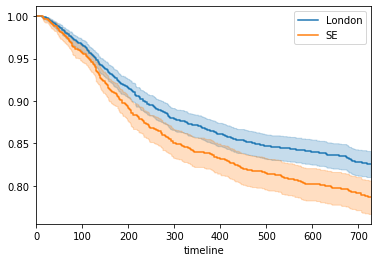

In [69]:
kmf2 = KaplanMeierFitter()

kmf2.fit(T2[ldn], E2[ldn], label='London')
a2 = kmf2.plot(loc=slice(0, 730))


kmf2.fit(T2[se], E2[se], label='SE')

kmf2.plot(ax=a2, loc=slice(0, 730))